In [2]:
import time
import torch
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as dset
from IPython.display import display, clear_output
from torch.autograd import Variable

In [3]:
def status(batch_size, ep, epoch, i, loss, acc, data_loader):
    # status
    clear_output(wait=True)
    print(str(ep) + '/' + str(epoch))
    print('batch: ' + str(i+1) + '/' + str(len(data_loader)) + 
             ' [' + '='*int((i+1)/(len(data_loader)/20)) +
              '>' + ' '*(20 - int((i+1)/(len(data_loader)/20))) +
              ']')
    print('Loss: %.4g '% ((loss / ((i+1)*batch_size))))
    
#-------------------------------------------------------------------
def conv(dimIn, dimOut):
    model = nn.Sequential(
        nn.Conv2d(dimIn, dimOut, kernel_size=3, stride=1,
                  padding=1),
        nn.BatchNorm2d(dimOut),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(dimOut, dimOut, kernel_size=3, stride=1,
                 padding=1),
        nn.BatchNorm2d(dimOut)
    )
    return model

#-------------------------------------------------------------------
def pool():
    p = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return p

#-------------------------------------------------------------------
def invConv(dimIn, dimOut):
    model = nn.Sequential(
        nn.ConvTranspose2d(dimIn, dimOut, kernel_size=3, stride=2,
                           padding=1,output_padding=1),
        nn.BatchNorm2d(dimOut),
        nn.LeakyReLU(0.2, inplace=True)
    )
    
#-------------------------------------------------------------------
def last(dimIn, dimOut):
    model = nn.Sequential(
        nn.Conv2d(dimIn, dimOut, kernel_size=3, stride=1,
                  padding=1),
        nn.Tanh()
    )

In [4]:
class PezzGen(nn.Module):
    def __init__(self):
        super().__init__()
        #self.dimIn = dimIn
        #self.dimOut = dimOut
        #self.filterNum = filterNum
        #actFun = nn.LeakyReLU(0.2, inplace=True)
        
        print("\n------Initializing PezzGen------\n")
        
        self.conv1 = conv(3, 6)
        self.pool1 = pool()
        self.conv2 = conv(6, 12)
        self.pool2 = pool()
        
        self.bridge = conv(12, 24)
        
        self.inv1 = invConv(24, 12)
        self.up1 = conv(24, 12)
        self.inv2 = invConv(12, 6)
        self.up2 = conv(12, 6)
        
        self.last = last(6, 12)
        
    def forward(self, img):
        conv1 = self.conv1(img)
        pool1 = self.pool1(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)
        
        bridge = self.bridge(pool2)
        
        inv1 = self.inv1(bridge)
        join1 = torch.cat([inv1, conv2],dim=1)
        up1 = self.up1(join1)
        inv2 = self.inv2(up1)
        join2 = torch.cat([inv2, conv1],dim=1)
        up2 = self.up2(join2)
        
        res = self.last(up2)
        return res

net = PezzGen()
              


------Initializing PezzGen------



In [4]:
# parameters
batch_size = 50
img_size = 256
lr = 0.1
epoch = 5

# Generator
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = nn.DataParallel(net)

img_dir = "./maps/"
trainset = dset.ImageFolder(root=img_dir,
                            transform = transforms.Compose([
                            transforms.Scale(size=img_size),
                            transforms.CenterCrop(size=(img_size,
                            img_size*2)),
                            transforms.ToTensor(),
                            ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, 
                                          num_workers=2)

recon_loss_func = nn.MSELoss()
gen_optimizer = torch.optim.Adam(net.parameters(),lr=lr)




/home/peppe/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:207: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [5]:
for ep in range(epoch):
    for i, (image, label) in enumerate(trainloader):
        
        satel_image, map_image = torch.chunk(image, chunks=2, dim=3)
        
        gen_optimizer.zero_grad()
        
        # print data
        #im = im[0,:,:,:]
        #print(image.shape)
        #plt.imshow(np.transpose(im, (1, 2, 0)))
        #plt.show()
        #im = satel_image[0,:,:,:]
        #plt.imshow(np.transpose(im, (1, 2, 0)))
        #plt.show()
        
        #time.sleep(2)
        
        x = Variable(satel_image).cuda(0) # add .cuda(0) for parallel
        y_ = Variable(map_image).cuda(0)
        y = generator.forward(x)
        
        current_loss = recon_loss_func(y,y_)
        current_loss.backward()
        gen_optimizer.step()
        current_acc = np.array(1)
        
        # status
        status(batch_size, ep+1 , epoch, i, current_loss,
               current_acc, trainloader)
        

5/5
batch: 549/549 [====================>]
Loss: 3.727e-07   Accuracy: 3.643e-05


torch.Size([4, 3, 256, 256])


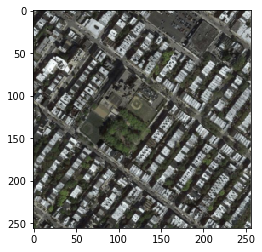

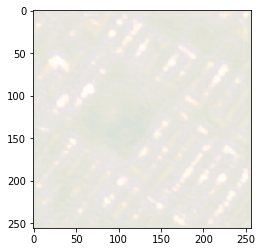

In [13]:
with torch.no_grad():
    for (data, label) in trainloader:
        img, ideal = torch.chunk(data, chunks=2, dim=3)
        
        print(img.shape)
        
        image = img[0,:,:,:].detach()
        #print(image.shape)
        plt.imshow(np.transpose(image, (1,2,0)))
        plt.show()
        
        #plt.figsize(20,15)
        #plt.subplot(221)
        #plt.imshow()
        
        #x = Variable(img).cuda(0)
        x = Variable(img)
        
        res = generator.forward(x)
        res = res.cpu()
        
        image = res[0,:,:,:].detach()
        #print(image.shape)
        plt.imshow(np.transpose(image, (1,2,0)))
        plt.show()
        
        break